<a href="https://colab.research.google.com/github/Cassembo/Univ_WP/blob/main/cat_dog_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

100%|██████████| 788M/788M [00:39<00:00, 21.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


In [ ]:
train_data_dir = path + '/PetImages'

In [ ]:
def is_valid_image(filepath):
    try:
        img = Image.open(filepath)
        img.verify()  # Verify the image integrity
        return True
    except (IOError, SyntaxError):
        return False

# Collect valid image file paths
valid_image_filepaths = []
for folder in ['Cat', 'Dog']:
    folder_path = os.path.join(train_data_dir, folder)
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if is_valid_image(filepath):
            valid_image_filepaths.append(filepath)

# Print number of valid images collected
print(f"Valid images collected: {len(valid_image_filepaths)}")

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Valid images collected: 24998


In [ ]:
def clean_invalid_images(data_dir):
    removed_images_count = 0
    for folder in ['Cat', 'Dog']:
        folder_path = os.path.join(data_dir, folder)
        for filename in os.listdir(folder_path):
            filepath = os.path.join(folder_path, filename)
            if not is_valid_image(filepath):
                print(f"Removing corrupt image: {filepath}")
                try:
                    os.remove(filepath)
                    removed_images_count += 1
                except Exception as e:
                    print(f"Error removing image {filepath}: {e}")
    print(f"Total corrupted images removed: {removed_images_count}")

# Clean invalid images
clean_invalid_images(train_data_dir)

Removing corrupt image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/Thumbs.db
Removing corrupt image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/666.jpg
Removing corrupt image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/Thumbs.db
Removing corrupt image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/11702.jpg
Total corrupted images removed: 4


In [ ]:
def safe_image_generator(generator):
    while True:
        try:
            yield next(generator)
        except Exception as e:
            print(f"Error in data generator: {e}")

In [ ]:
img_width, img_height = 150, 150
batch_size = 32

In [ ]:
# Create an ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # Assuming you have two classes: cats and dogs
)

# Create a safe generator
safe_train_generator = safe_image_generator(train_generator)

Found 24998 images belonging to 2 classes.


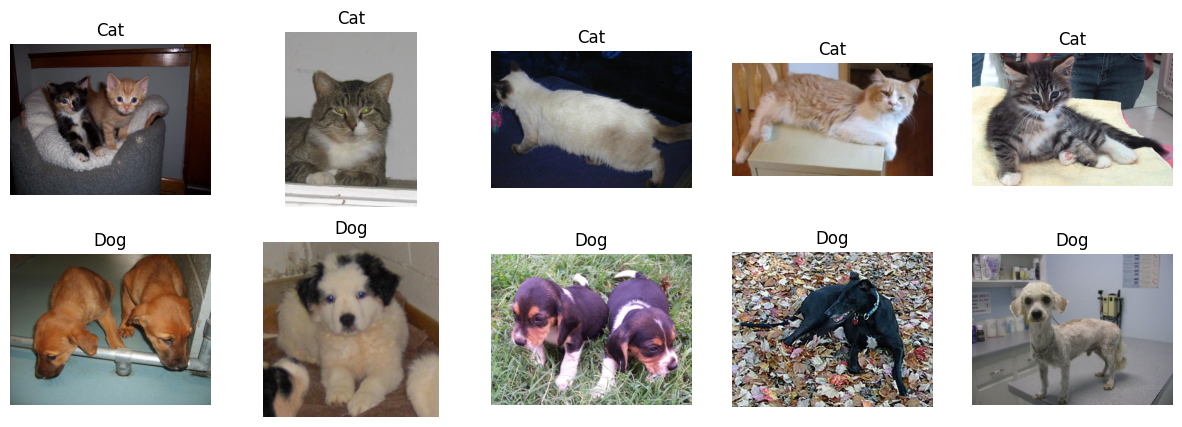

In [ ]:
# Get a list of all cat and dog image paths
cat_image_paths = [os.path.join(train_data_dir, 'Cat', filename) for filename in os.listdir(os.path.join(train_data_dir, 'Cat'))]
dog_image_paths = [os.path.join(train_data_dir, 'Dog', filename) for filename in os.listdir(os.path.join(train_data_dir, 'Dog'))]

# Select a random sample of cat and dog images
num_samples = 5  # You can change this to display more or fewer images
random_cat_images = np.random.choice(cat_image_paths, num_samples, replace=False)
random_dog_images = np.random.choice(dog_image_paths, num_samples, replace=False)

# Display the images
plt.figure(figsize=(15, 5))

for i, image_path in enumerate(random_cat_images):
    plt.subplot(2, num_samples, i + 1)
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title('Cat')
    plt.axis('off')

for i, image_path in enumerate(random_dog_images):
    plt.subplot(2, num_samples, i + 1 + num_samples)
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title('Dog')
    plt.axis('off')

plt.show()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       9,470,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,526,529 (36.34 MB)

 Trainable params: 9,526,529 (36.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model and save the history
history = model.fit(
    safe_train_generator,
    steps_per_epoch=len(train_generator),  # Adjust as needed
    epochs=20
)

Epoch 1/20
559/782 ━━━━━━━━━━━━━━━━━━━━ 47s 212ms/step - accuracy: 0.5830 - loss: 0.6799

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


782/782 ━━━━━━━━━━━━━━━━━━━━ 174s 215ms/step - accuracy: 0.5945 - loss: 0.6698
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 165s 211ms/step - accuracy: 0.7027 - loss: 0.5659
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 166s 213ms/step - accuracy: 0.7620 - loss: 0.4925
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 214ms/step - accuracy: 0.8011 - loss: 0.4344
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 214ms/step - accuracy: 0.8257 - loss: 0.3886
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.8404 - loss: 0.3597
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8559 - loss: 0.3295
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.8729 - loss: 0.2991
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - accuracy: 0.8811 - loss: 0.2767
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 214ms/step - accuracy: 0.8925 - loss: 0.2567
Epoch 11/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.9023 - loss: 0.2346
Epoch 12/20
782/782

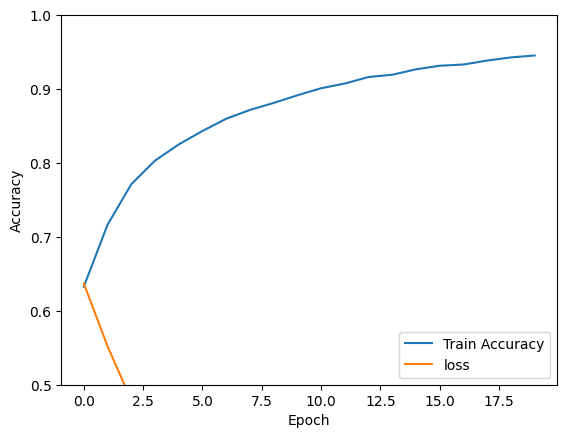

In [ ]:
# Plotting accuracy and loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Evaluate the model
evaluation = model.evaluate(safe_train_generator, steps=5)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.9032 - loss: 0.2433


In [ ]:
#Print the evaluation metrics (loss and accuracy)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")

Validation Loss: 0.24539586901664734
Validation Accuracy: 0.90625


In [ ]:
# def plot_prediction(generator, n_images):
#     """
#     Test the model on random predictions
#     Args:
#     generator: a generator instance
#     n_images : number of images to plot

#     """
#     i = 1
#     # Get the images and the labels from the generator
#     images, labels = generator.next()
#     # Gets the model predictions
#     preds = model.predict(images)
#     predictions = np.argmax(preds, axis=1)
#     labels = labels.astype('int32')
#     plt.figure(figsize=(14, 15))
#     for image, label in zip(images, labels):
#         plt.subplot(4, 3, i)
#         plt.imshow(image)
#         if predictions[i] == labels[i]:
#             title_obj = plt.title(class_names[label])
#             plt.setp(title_obj, color='g')
#             plt.axis('off')
#         else:
#             title_obj = plt.title(class_names[label])
#             plt.setp(title_obj, color='r')
#             plt.axis('off')
#         i += 1
#         if i == n_images:
#             break

#     plt.show()